<a href="https://colab.research.google.com/github/mandavi-singh/age-group-classification-ml-hackathon/blob/main/NHANES_Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb


## **Load Data**

In [ ]:
train = pd.read_csv('/content/Train_Data.csv')
test = pd.read_csv('/content/Test_Data.csv')
sample_submission = pd.read_csv('/content/Sample_Submission.csv')


In [ ]:
print(" Train shape:", train.shape)

 Train shape: (1966, 10)


In [ ]:
print("Test shape:", test.shape)

Test shape: (312, 9)


In [ ]:
print(train.head())

      SEQN  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN  \
0  73564.0      61.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91   
1  73568.0      26.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85   
2  73576.0      16.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14   
3  73577.0      32.0       1.0     2.0    28.9   104.0     NaN    84.0  16.15   
4  73580.0      38.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92   

  age_group  
0     Adult  
1     Adult  
2     Adult  
3     Adult  
4     Adult  


In [ ]:
print(test.head())

      SEQN  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0  77017.0      34.0       1.0     1.0    32.2    96.0     2.0   135.0  15.11
1  75580.0      12.0       2.0     2.0    26.3   100.0     2.0   141.0  15.26
2  73820.0      56.0       1.0     2.0    28.6   107.0     2.0   136.0   8.82
3  80489.0      20.0       2.0     1.0    22.1    93.0     2.0   111.0  12.13
4  82047.0      64.0       1.0     1.0    24.7    91.0     2.0   105.0   3.12


In [ ]:
print(train.columns)

Index(['SEQN', 'RIDAGEYR', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010',
       'LBXGLT', 'LBXIN', 'age_group'],
      dtype='object')


In [ ]:
print(test.columns)

Index(['SEQN', 'RIDAGEYR', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010',
       'LBXGLT', 'LBXIN'],
      dtype='object')


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIDAGEYR   1957 non-null   float64
 2   RIAGENDR   1948 non-null   float64
 3   PAQ605     1953 non-null   float64
 4   BMXBMI     1948 non-null   float64
 5   LBXGLU     1953 non-null   float64
 6   DIQ010     1948 non-null   float64
 7   LBXGLT     1955 non-null   float64
 8   LBXIN      1957 non-null   float64
 9   age_group  1952 non-null   object 
dtypes: float64(9), object(1)
memory usage: 153.7+ KB
None


In [ ]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      310 non-null    float64
 1   RIDAGEYR  309 non-null    float64
 2   RIAGENDR  310 non-null    float64
 3   PAQ605    311 non-null    float64
 4   BMXBMI    311 non-null    float64
 5   LBXGLU    311 non-null    float64
 6   DIQ010    311 non-null    float64
 7   LBXGLT    310 non-null    float64
 8   LBXIN     311 non-null    float64
dtypes: float64(9)
memory usage: 22.1 KB
None


In [ ]:
column_info = {
    'SEQN': 'ID number',
    'RIDAGEYR': 'Age in years',
    'RIAGENDR': 'Gender (1=Male, 2=Female)',
    'PAQ605': 'Weekly sports/exercise',
    'BMXBMI': 'Body Mass Index',
    'LBXGLU': 'Blood glucose level',
    'DIQ010': 'Diabetes answer',
    'LBXGLT': 'Glucose tolerance (Oral)',
    'LBXIN': 'Insulin level'
}

info_df = pd.DataFrame(list(column_info.items()), columns=['Column', 'Meaning'])
print(info_df)

     Column                    Meaning
0      SEQN                  ID number
1  RIDAGEYR               Age in years
2  RIAGENDR  Gender (1=Male, 2=Female)
3    PAQ605     Weekly sports/exercise
4    BMXBMI            Body Mass Index
5    LBXGLU        Blood glucose level
6    DIQ010            Diabetes answer
7    LBXGLT   Glucose tolerance (Oral)
8     LBXIN              Insulin level


In [ ]:
target_info = pd.DataFrame({
    'Label': [0, 1],
    'Meaning': ['Adult (less than 65)', 'Senior (65 and above)']
})
print(target_info)

   Label                Meaning
0      0   Adult (less than 65)
1      1  Senior (65 and above)


In [ ]:
print(train.describe())

               SEQN     RIDAGEYR     RIAGENDR       PAQ605       BMXBMI  \
count   1954.000000  1957.000000  1948.000000  1953.000000  1948.000000   
mean   78683.621801    42.005621     1.510267     1.825397    27.965400   
std     2924.115709    20.147601     0.500023     0.399449     7.327616   
min    73564.000000    12.000000     1.000000     1.000000    14.500000   
25%    76194.000000    24.000000     1.000000     2.000000    22.800000   
50%    78717.000000    41.000000     2.000000     2.000000    26.800000   
75%    81217.000000    58.000000     2.000000     2.000000    31.300000   
max    83727.000000    80.000000     2.000000     7.000000    70.100000   

            LBXGLU       DIQ010       LBXGLT        LBXIN  
count  1953.000000  1948.000000  1955.000000  1957.000000  
mean     99.491039     2.015914   115.150384    11.862892  
std      16.774665     0.187579    46.271615     9.756713  
min      63.000000     1.000000    40.000000     0.140000  
25%      91.000000     2

In [ ]:
print(test.describe())

               SEQN    RIDAGEYR    RIAGENDR      PAQ605      BMXBMI  \
count    310.000000  309.000000  310.000000  311.000000  311.000000   
mean   78717.490323   40.569579    1.522581    1.803859   27.810611   
std     2905.999069   20.272955    0.500297    0.397717    6.717031   
min    73659.000000   12.000000    1.000000    1.000000   15.900000   
25%    76006.500000   21.000000    1.000000    2.000000   22.950000   
50%    79036.500000   39.000000    2.000000    2.000000   26.800000   
75%    81167.000000   56.000000    2.000000    2.000000   30.900000   
max    83694.000000   80.000000    2.000000    2.000000   54.900000   

           LBXGLU      DIQ010      LBXGLT       LBXIN  
count  311.000000  311.000000  310.000000  311.000000  
mean   100.067524    2.019293  114.241935   11.666463  
std     23.920539    0.159477   52.356101    9.570438  
min     69.000000    1.000000   43.000000    1.040000  
25%     92.000000    2.000000   86.000000    6.120000  
50%     97.000000    2.0

# **Preprocessing**

In [ ]:
# Drop ID column
X = train.drop(['SEQN', 'age_group'], axis=1)
y = train['age_group']
X_test = test.drop(['SEQN'], axis=1)


# **Handle Missing Values**

In [ ]:
X = X.fillna(X.mean())
X_test = X_test.fillna(X.mean())





In [ ]:
print(X_test)

     RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0        34.0       1.0     1.0    32.2    96.0     2.0   135.0  15.11
1        12.0       2.0     2.0    26.3   100.0     2.0   141.0  15.26
2        56.0       1.0     2.0    28.6   107.0     2.0   136.0   8.82
3        20.0       2.0     1.0    22.1    93.0     2.0   111.0  12.13
4        64.0       1.0     1.0    24.7    91.0     2.0   105.0   3.12
..        ...       ...     ...     ...     ...     ...     ...    ...
307      20.0       2.0     2.0    21.9    82.0     2.0    82.0   2.54
308      34.0       2.0     1.0    33.3    95.0     2.0    77.0   6.36
309      64.0       2.0     2.0    41.5    91.0     2.0   149.0  15.52
310      23.0       2.0     2.0    22.5    82.0     2.0    93.0   1.39
311      12.0       1.0     2.0    16.1    96.0     2.0   197.0   8.57

[312 rows x 8 columns]


In [ ]:
#Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
mean_vals = X_train.mean()

X_train = X_train.fillna(mean_vals)
X_val = X_val.fillna(mean_vals)
X_test = X_test.fillna(mean_vals)

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_s = scaler.fit_transform(X)
X_test_s = scaler.transform(X_test)


In [ ]:
print("Columns with NaN in X_train:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])


Columns with NaN in X_train:
Series([], dtype: int64)


In [ ]:
if isinstance(X_train, pd.DataFrame):
    print(X_train.dtypes)
else:
    print(X_train.dtype)


RIDAGEYR    float64
RIAGENDR    float64
PAQ605      float64
BMXBMI      float64
LBXGLU      float64
DIQ010      float64
LBXGLT      float64
LBXIN       float64
dtype: object


In [ ]:
import numpy as np

print("NaNs in X_train:", np.isnan(X_train).sum().sum())
print("NaNs in X_val:", np.isnan(X_val).sum().sum())
print("NaNs in X_test:", np.isnan(X_test).sum().sum())


NaNs in X_train: 0
NaNs in X_val: 0
NaNs in X_test: 0


In [ ]:
print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1572, 8)
(1572,)


In [ ]:
print("NaNs in X_train:", np.isnan(X_train).sum().sum())


NaNs in X_train: 0


In [ ]:
print("NaNs in y_train:", y_train.isnull().sum())
print("Unique values in y_train:", y_train.unique())


NaNs in y_train: 13
Unique values in y_train: ['Adult' 'Senior' nan]


In [ ]:

y = train['age_group'].map({'Adult': 0, 'Senior': 1})


In [ ]:
y = y.fillna(y.mode()[0])


In [ ]:
X = train.drop(['SEQN', 'age_group'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(test.drop(['SEQN'], axis=1)), columns=X.columns)


In [ ]:
X_train = X_train.reset_index(drop=True).astype(float)
X_val = X_val.reset_index(drop=True).astype(float)
X_test = X_test.reset_index(drop=True).astype(float)
y_train = y_train.reset_index(drop=True).astype(int)
y_val = y_val.reset_index(drop=True).astype(int)


In [ ]:
print(y_train.unique())
print(y_train.isnull().sum())


[0 1]
0


# **Logistic Regression**

In [ ]:
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
lr_l2.fit(X_train, y_train)
lr_preds = lr_l2.predict(X_val)
print("L2 Logistic Regression F1:", f1_score(y_val, lr_preds))

lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lr_l1.fit(X_train, y_train)
lr1_preds = lr_l1.predict(X_val)
print("L1 Logistic Regression F1:", f1_score(y_val, lr1_preds))

L2 Logistic Regression F1: 0.8596491228070176
L1 Logistic Regression F1: 0.9369369369369369


**SVM**

In [ ]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_s, y_train)
svm_preds = svm.predict(X_val_s)
print("SVM F1:", f1_score(y_val, svm_preds))

SVM F1: 0.8648648648648649


In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

svm_best = grid.best_estimator_
svm_cv_scores = cross_val_score(svm_best, X_train, y_train, cv=5, scoring='f1')
print("SVM Cross-Validation F1:", svm_cv_scores.mean())



Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVM Cross-Validation F1: 0.9806945481702762


# **Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)
print("Decision Tree F1:", f1_score(y_val, dt_preds))

Decision Tree F1: 0.990990990990991


# **Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print("Random Forest F1:", f1_score(y_val, rf_preds))

Random Forest F1: 1.0


# **K-Nearest Neighbours (KNN)**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train)
knn_preds = knn.predict(X_val_s)
print("KNN F1:", f1_score(y_val, knn_preds))

KNN F1: 0.75


# **Gaussian Naive Bayes**

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_val)
print("Gaussian NB F1:", f1_score(y_val, gnb_preds))

Gaussian NB F1: 0.7933884297520661


# **XGBoost**

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
print("XGBoost F1:", f1_score(y_val, xgb_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:52:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost F1: 1.0


# **LightGBM**

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_val)
print("LightGBM F1:", f1_score(y_val, lgb_preds))


[LightGBM] [Info] Number of positive: 258, number of negative: 1314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 1572, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164122 -> initscore=-1.627872
[LightGBM] [Info] Start training from score -1.627872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

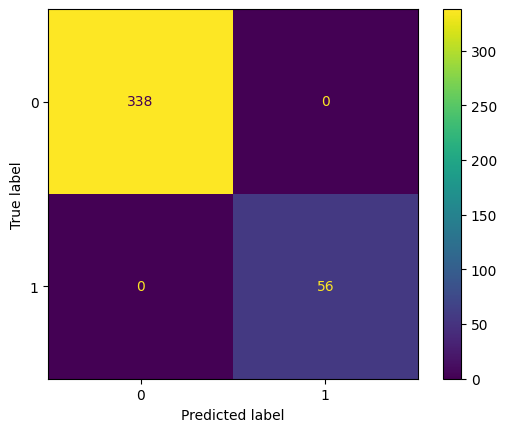

Random Forest AUC: 1.0


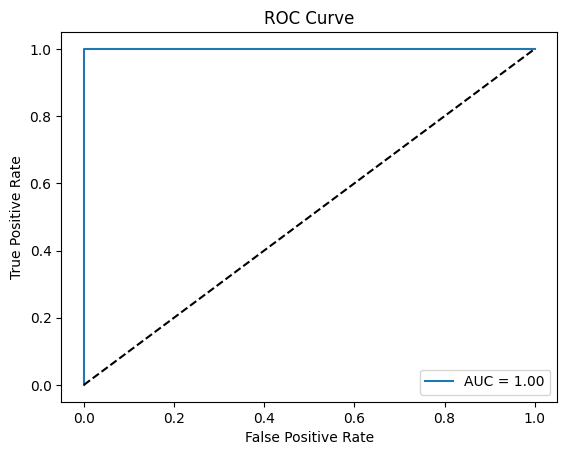

In [ ]:
# Confusion Matrix & ROC for BEST MODEL
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

probs = rf.predict_proba(X_val)[:,1]
cm = confusion_matrix(y_val, rf_preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()

auc = roc_auc_score(y_val, probs)
print("Random Forest AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_val, probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
rf.fit(X, y)
final_preds = rf.predict(X_test)


/tmp/ipython-input-47-3557768926.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


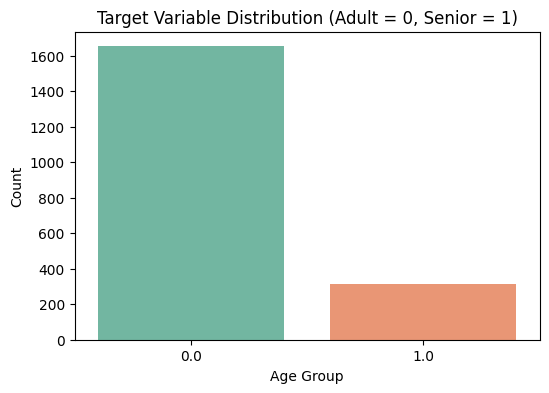

In [ ]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Target Variable Distribution (Adult = 0, Senior = 1)")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

/tmp/ipython-input-49-4026992422.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X['BMXBMI'], palette="Set3")


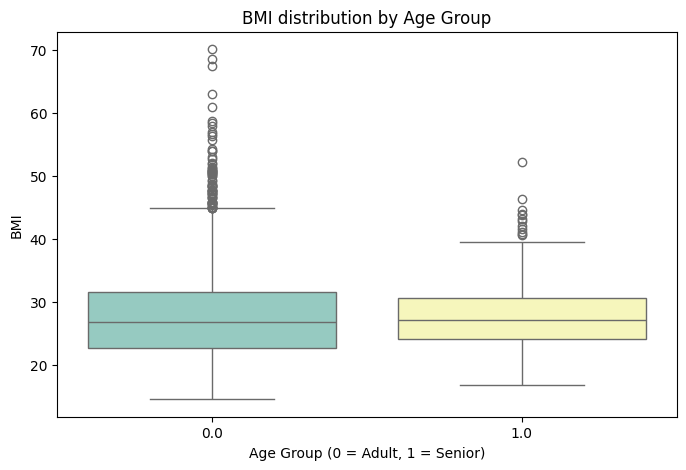

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y, y=X['BMXBMI'], palette="Set3")
plt.title("BMI distribution by Age Group")
plt.xlabel("Age Group (0 = Adult, 1 = Senior)")
plt.ylabel("BMI")
plt.show()


/tmp/ipython-input-50-1574860658.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette="viridis")


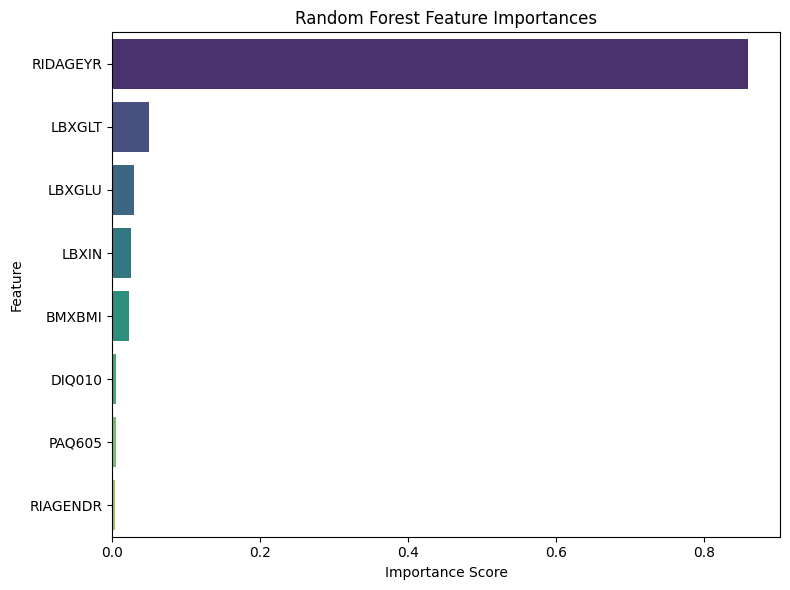

In [ ]:
importances = rf.feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


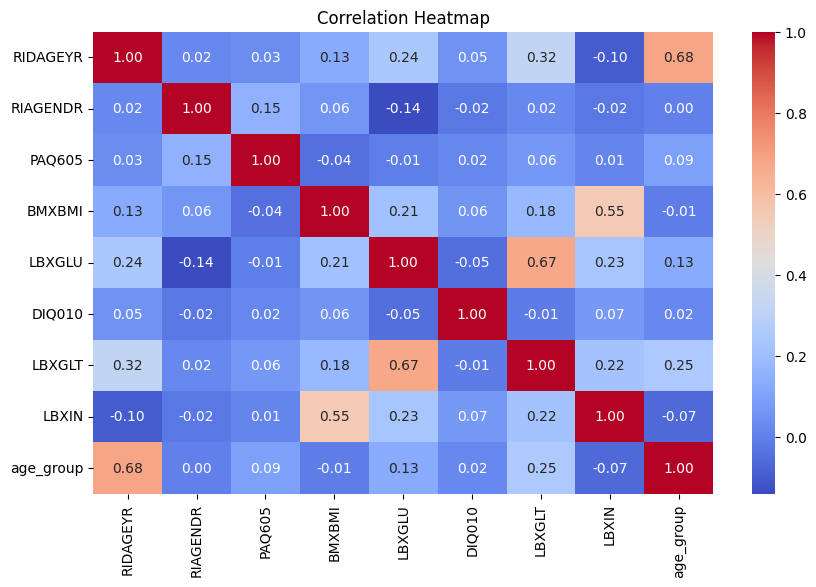

In [ ]:
train_corr = train.copy()
train_corr['age_group'] = train_corr['age_group'].map({'Adult': 0, 'Senior': 1})

plt.figure(figsize=(10, 6))
sns.heatmap(train_corr.drop(['SEQN'], axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


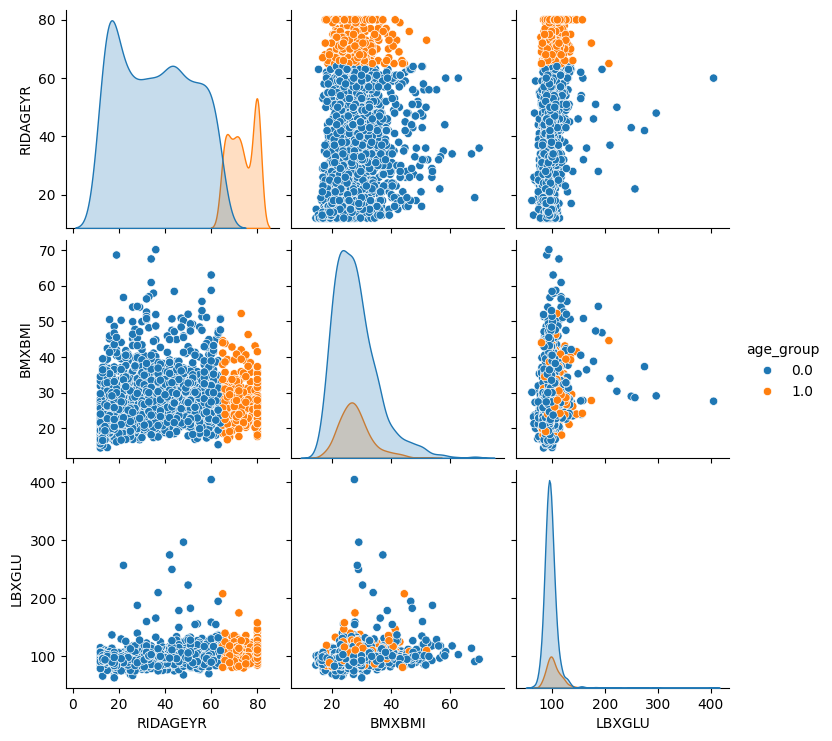

In [ ]:
sns.pairplot(train_corr[['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'age_group']], hue='age_group')
plt.show()

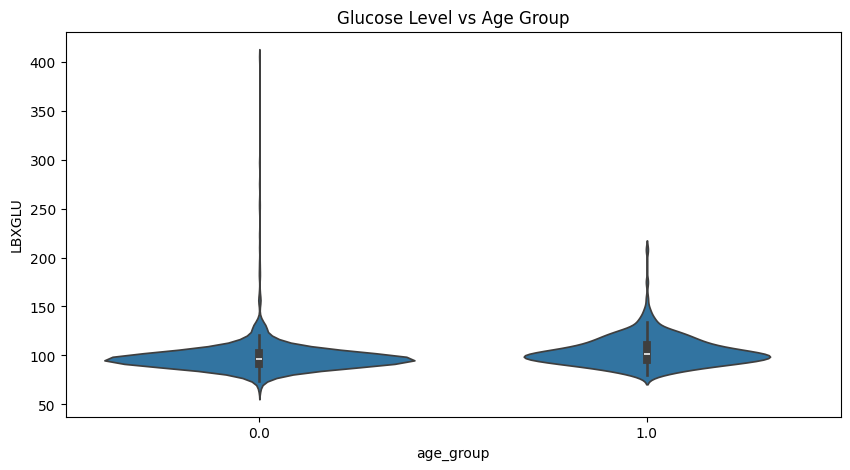

In [ ]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='age_group', y='LBXGLU', data=train_corr)
plt.title('Glucose Level vs Age Group')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)


Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.976582589971488


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid_rf.fit(X_train, y_train)

print("RF Best Params:", grid_rf.best_params_)
print("RF Best F1:", grid_rf.best_score_)


RF Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RF Best F1: 0.9903655891034532


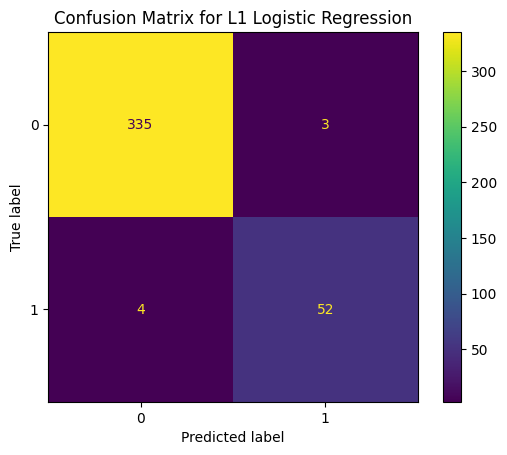

In [ ]:
y_pred = lr_l1.predict(X_val)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title("Confusion Matrix for L1 Logistic Regression")
plt.show()


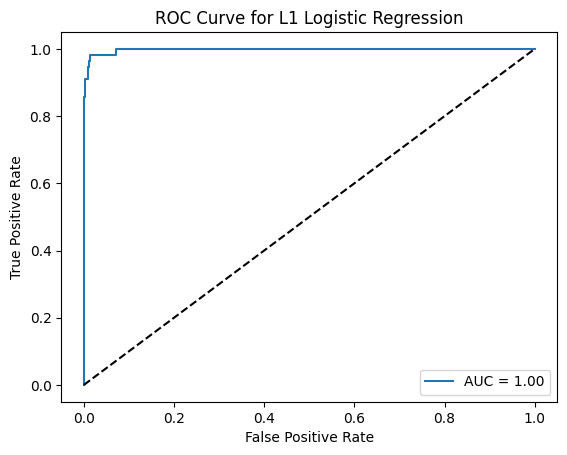

In [ ]:
y_proba = lr_l1.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)


plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for L1 Logistic Regression')
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X, y)


RandomForestClassifier(random_state=42)

In [ ]:
final_predictions = rf_final.predict(X_test)
unique, counts = np.unique(final_predictions, return_counts=True)
print(dict(zip(unique, counts)))


{np.float64(0.0): np.int64(266), np.float64(1.0): np.int64(46)}


In [ ]:
submission['age_group'] = submission['age_group'].astype(int)
submission.to_csv('final_submission.csv', index=False)

print(submission.head())
print(submission['age_group'].value_counts())


   age_group
0          0
1          0
2          0
3          0
4          0
age_group
0    266
1     46
Name: count, dtype: int64


In [ ]:
print(submission.shape[0])
print(X_test.shape[0])

312
312


In [ ]:
final_submission = pd.read_csv('final_submission.csv')
sample_submission = pd.read_csv('Sample_Submission.csv')


print("Final Submission value counts:")
print(final_submission['age_group'].value_counts())

print("\nSample Submission value counts:")
print(sample_submission['age_group'].value_counts())


Final Submission value counts:
age_group
0    266
1     46
Name: count, dtype: int64

Sample Submission value counts:
age_group
0    262
1     50
Name: count, dtype: int64
